**This project aims to detect Covid-19 from X-ray images and distinguish it from viral and bacterial pneumonia. A custom dataset was created, comprising X-ray images of Covid-19 cases, viral pneumonia, bacterial pneumonia, and healthy individuals. Each class contains 133 images.**

## Dataset info

I utilized data from this https://github.com/ieee8023/covid-chestxray-dataset and https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. The dataset is organized into four folders:

0 – Covid-19 X-ray  
1 – Normal X-ray  
2 – Viral Pneumonia X-ray  
3 – Bacterial Pneumonia X-ray  

## Import Libraries

In [126]:
import os
# import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Import Data

In [127]:
X_RAY_DIRECTORY = 'X-Ray_Images\Dataset'

In [128]:
os.listdir(X_RAY_DIRECTORY)

['0', '1', '2', '3']

### Split data (train/validation)

In [129]:
image_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [130]:
train_gen = image_gen.flow_from_directory(directory=X_RAY_DIRECTORY, 
                                          batch_size=40, 
                                          target_size=(255, 255), 
                                          shuffle=True,
                                          class_mode='categorical',
                                          subset='training')

Found 428 images belonging to 4 classes.


In [131]:
validation_gen = image_gen.flow_from_directory(directory=X_RAY_DIRECTORY, 
                                               batch_size=40, 
                                               target_size=(255, 255), 
                                               shuffle=True,
                                               class_mode='categorical',
                                               subset='validation')

Found 104 images belonging to 4 classes.


In [132]:
train_images, train_labels = next(train_gen)

In [133]:
train_images.shape

(40, 255, 255, 3)

In [134]:
train_labels.shape

(40, 4)

In [135]:
labels = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

### Data visualisation

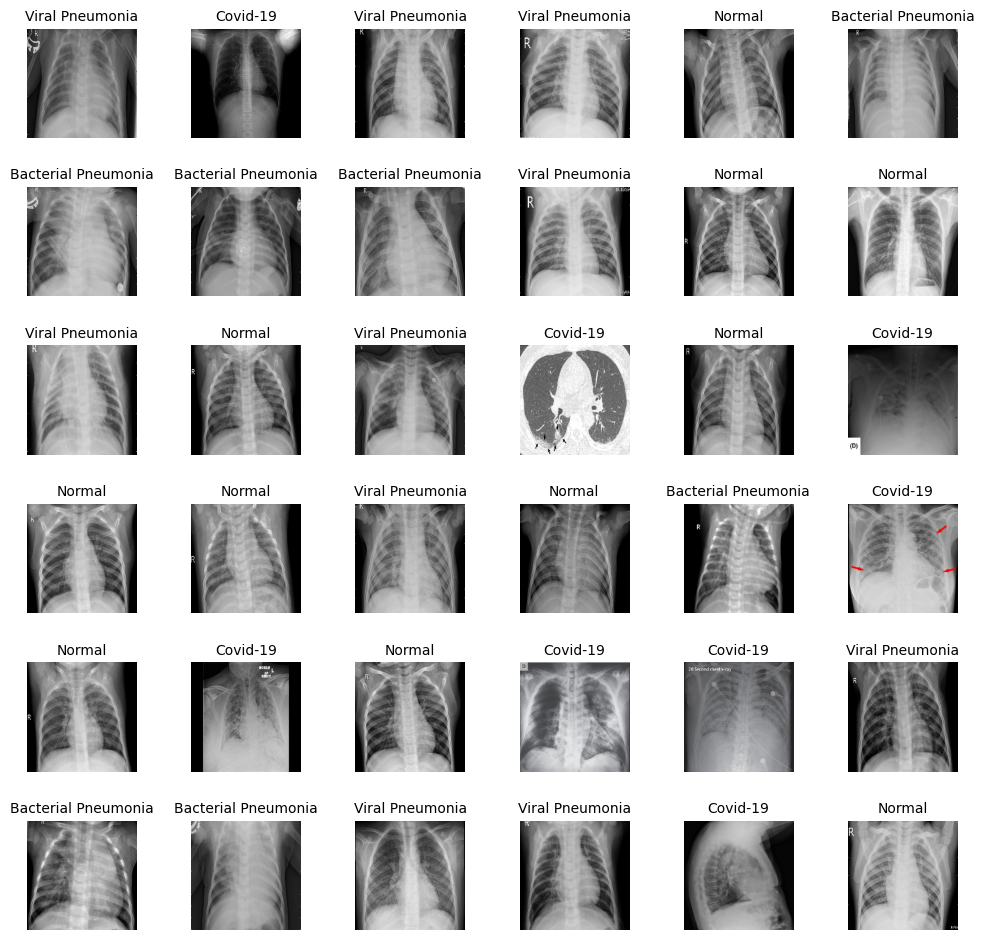

In [136]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()  #flatten axes

for i in np.arange(6*6):
    axes[i].imshow(train_images[i])
    axes[i].set_title(labels[np.argmax(train_labels[i])], fontsize=10)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

## Model

### Pretrained ResNet model uploading

In [137]:
# input_tensor = Input(shape=(256, 256, 3)) 

In [138]:
basemodel = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [139]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 262, 262, 3)       │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 64, 64, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [140]:
# freeze layers
for layer in basemodel.layers[:-10]:
    layers.trainable = False   

### Add top CNN layers to base model (ResNet50)

In [141]:
head = basemodel.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.5)(head)
head = Dense(128, activation='relu')(head)
head = Dropout(0.4)(head)
head = Dense(4, activation='softmax')(head)

In [142]:
model = Model(inputs=basemodel.input, outputs = head)

### Model compilation

In [143]:
model.compile(loss='categorical_crossentropy', optimizer= optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])

In [144]:
# validation error checking
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [145]:
# save best model (min val loss)
best_model_checkpoint = ModelCheckpoint(filepath = 'model_last_checkpoint.keras', verbose=1, save_best_only=True)

In [146]:
# find optimal learning rate
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00005)

In [147]:
train_img_generator = image_gen.flow_from_directory(directory=X_RAY_DIRECTORY, 
                                                    batch_size=5, 
                                                    shuffle=True, 
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    subset='training')

Found 428 images belonging to 4 classes.


In [148]:
val_img_generator = image_gen.flow_from_directory(directory=X_RAY_DIRECTORY, 
                                                    batch_size=5, 
                                                    shuffle=True, 
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    subset='validation')

Found 104 images belonging to 4 classes.


In [149]:
history = model.fit(train_img_generator, 
                              epochs=25, 
                              validation_data=val_img_generator,
                              callbacks=[best_model_checkpoint, early_stop])

Epoch 1/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.4268 - loss: 1.5385
Epoch 1: val_loss improved from inf to 8.88326, saving model to model_last_checkpoint.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 86s 814ms/step - accuracy: 0.4282 - loss: 1.5344 - val_accuracy: 0.2500 - val_loss: 8.8833
Epoch 2/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.8329 - loss: 0.4850
Epoch 2: val_loss did not improve from 8.88326
86/86 ━━━━━━━━━━━━━━━━━━━━ 63s 735ms/step - accuracy: 0.8327 - loss: 0.4863 - val_accuracy: 0.2500 - val_loss: 27.6380
Epoch 3/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.8297 - loss: 0.5498
Epoch 3: val_loss did not improve from 8.88326
86/86 ━━━━━━━━━━━━━━━━━━━━ 65s 758ms/step - accuracy: 0.8297 - loss: 0.5498 - val_accuracy: 0.2500 - val_loss: 86.1598
Epoch 4/25
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.8841 - loss: 0.3678
Epoch 4: val_loss did not improve from 8.88326
86/86 ━━━━━━━━━━━━━━━━━━━━ 65s 758ms/step - accuracy: 0.8842 - loss

### Model Evaluation

In [150]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0, 0.5, 'Training accuracy and loss')

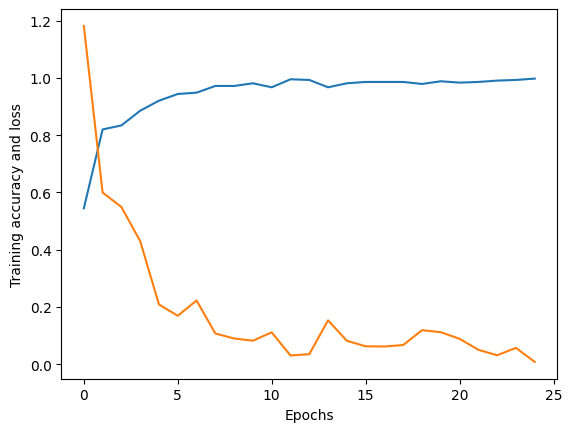

In [151]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training accuracy and loss")

Text(0, 0.5, 'Validation loss')

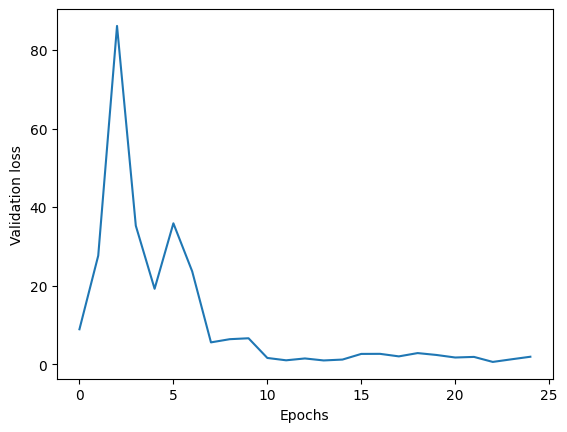

In [152]:
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Validation loss")

Text(0, 0.5, 'Validation accuracy')

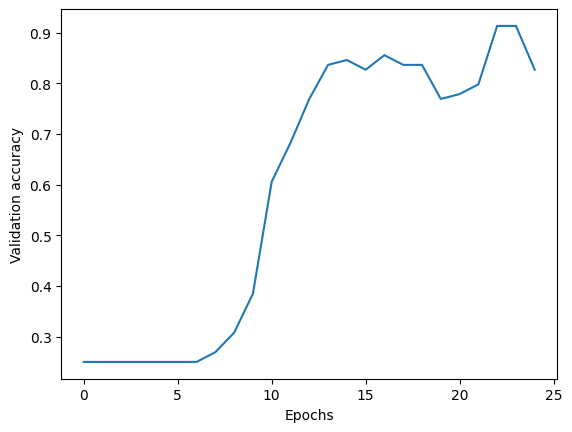

In [153]:
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")

## Test data performance

In [156]:
TEST_DIR ='X-Ray_Images\Test'

In [158]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size=40, 
                                              directory = TEST_DIR, 
                                              shuffle=True, 
                                              target_size=(256, 256), 
                                              class_mode='categorical')

Found 40 images belonging to 4 classes.


In [160]:
evaluate = model.evaluate(test_generator, steps=test_generator.n // 4, verbose=1)
print("Accuracy: {}".format(evaluate[1]))

C:\Users\Татьяна\Desktop\GitHub\Data-Analysis\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7500 - loss: 2.7681
Accuracy: 0.75


C:\Users\Татьяна\Desktop\GitHub\Data-Analysis\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [161]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [164]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(TEST_DIR))):
    for item in os.listdir(os.path.join(TEST_DIR, str(i))):
        img = cv2.imread(os.path.join(TEST_DIR, str(i), item))
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img = img/256
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)        

NameError: name 'cv2' is not defined

In [166]:
from PIL import Image
import numpy as np
import os

image = []
prediction = []
original = []

for i in range(len(os.listdir(TEST_DIR))):
    class_dir = os.path.join(TEST_DIR, str(i))
    for item in os.listdir(class_dir):
        # Open image with Pillow
        img_path = os.path.join(class_dir, item)
        img = Image.open(img_path).convert("RGB")
        # Resize image to 256x256
        img = img.resize((256, 256))
        # Convert image to numpy array and normalize
        img_array = np.array(img) / 256.0
        image.append(img_array)
        # Prepare image for prediction (add batch dimension)
        img_input = img_array.reshape(-1, 256, 256, 3)
        predict = model.predict(img_input)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━

In [167]:
score = accuracy_score(original, prediction)
print(f'Test accuracy: {score}')

Test accuracy: 0.8


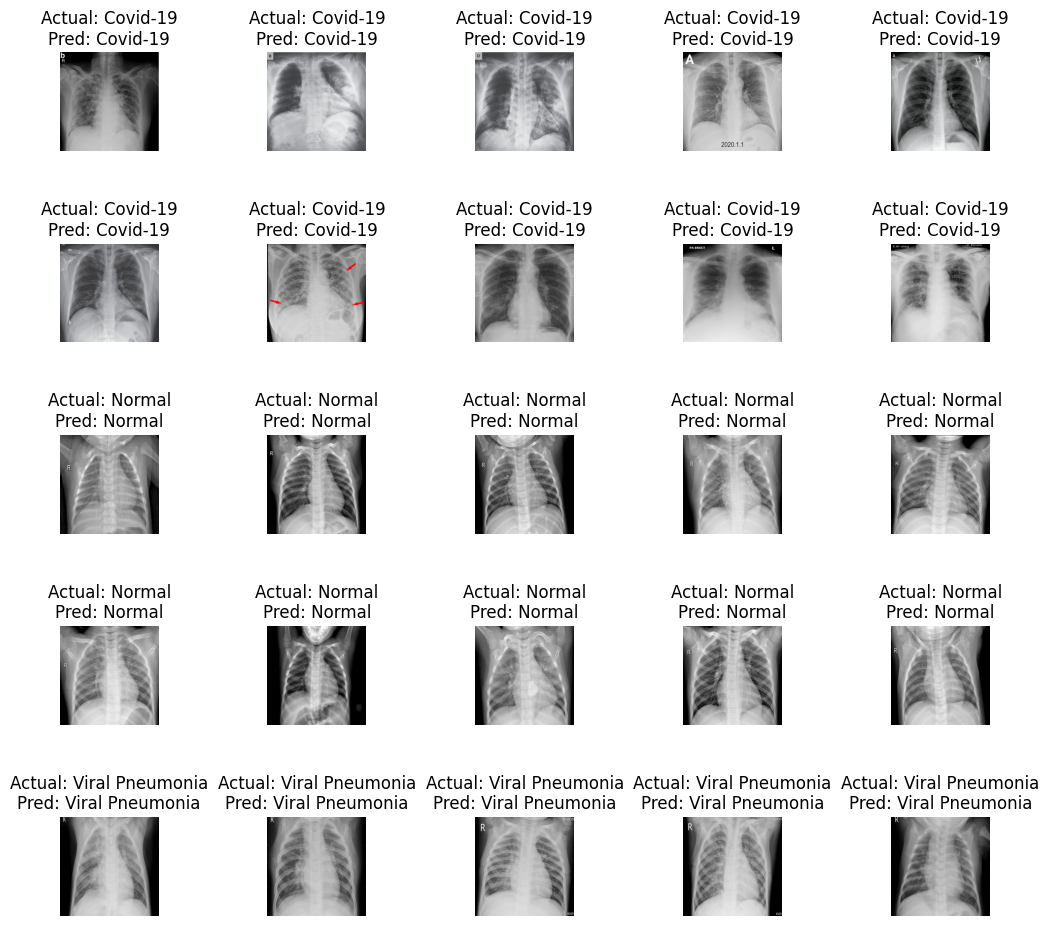

In [176]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in range(L * W):
    axes[i].imshow(image[i])
    axes[i].set_title('Actual: {}\nPred: {}'.format(labels[original[i]], labels[prediction[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1.1)
plt.show()

In [198]:
labels = ['Covid-19', 'Normal', 'Viral Pneumonia', 'Bacterial Pneumonia']

In [199]:
print(classification_report(np.asarray(original), np.asarray(prediction), target_names = labels))

                     precision    recall  f1-score   support

           Covid-19       0.83      1.00      0.91        10
             Normal       0.83      1.00      0.91        10
    Viral Pneumonia       0.70      0.70      0.70        10
Bacterial Pneumonia       0.83      0.50      0.62        10

           accuracy                           0.80        40
          macro avg       0.80      0.80      0.79        40
       weighted avg       0.80      0.80      0.79        40



The model achieves 80% accuracy overall, with a slightly lower performance for class 3 - 'Bacterial Pneumonia' (F1-score of 0.62) compared to classes Covid-19 and Normal (F1-score of 0.91)

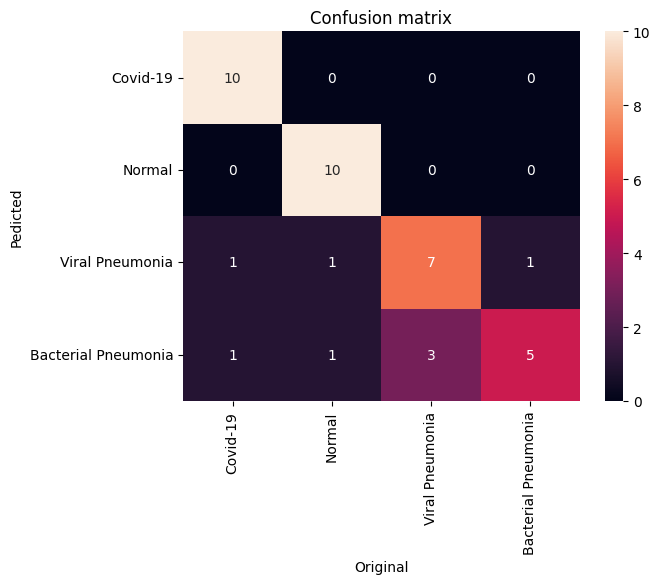

In [197]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)

ax.set_title('Confusion matrix')
ax.set_xlabel('Original')
ax.set_ylabel('Pedicted')
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)

plt.show()